![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/extras/style_transfer.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

## **Práctica Extra No. 3**

## **Transferencia de Estilo Neural**

## **Objetivos**
- Aprender a usar lo básico de custom loops
- Hacer un recorrido breve por la transferencia de estilo con una red autoadversaria



In [ ]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from utils import general as gen

from collections import OrderedDict
from typing import Dict, List, Tuple

from tqdm.auto import tqdm

## **Importando las librerías necesarias para el laboratorio**

In [ ]:
IMAGE_SIZE = (224, 224)

In [ ]:
def tensor_to_image(tensor: tf.Tensor) -> np.ndarray:
    """
    Function to transform a tensor to image
    :param tensor: The tensor to be transformed
    :type tensor: tf.Tensor
    :return: The tensor converted
    :rtype: np.ndarray
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    return tensor.squeeze()

In [ ]:
def load_image(img_path: str) -> tf.Tensor:
    """
    Function to load image
    :param img_path: 
    """
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.

    img_size = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(img_size)
    scale = max_dim / long_dim

    new_size = tf.cast(img_size * scale, tf.int32)

    img = tf.image.resize(img, new_size)
    img = img[tf.newaxis, ...]
    return img

In [ ]:
style_url = "https://www.artmajeur.com/medias/standard/a/r/"\
            "artdenoe/artwork/14121290_img-20210120-153931.jpg"
content_id = "1Ef2e27mn83lgtIB--8Yf7F7N_xXolMfh"
starry_night_url = "https://upload.wikimedia.org/wikipedia/"\
                   "commons/thumb/e/ea/Van_Gogh_-_Starry_Night"\
                   "_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_"\
                   "Starry_Night_-_Google_Art_Project.jpg"

In [ ]:
gen.download_content(style_url, "style_image.jpg")
gen.download_file_from_google_drive(content_id, "content_image.jpg")
gen.download_content(starry_night_url, "starry_night.jpg")

  0%|          | 0/95 [00:00<?, ?KB/s]

0KB [00:00, ?KB/s]

  0%|          | 0/614 [00:00<?, ?KB/s]

## **Lectura y Preparación**

In [ ]:
content_image = load_image("data/content_image.jpg")
style_image = load_image("data/style_image.jpg")

In [ ]:
content_image_array = tensor_to_image(content_image)
style_image_array = tensor_to_image(style_image)

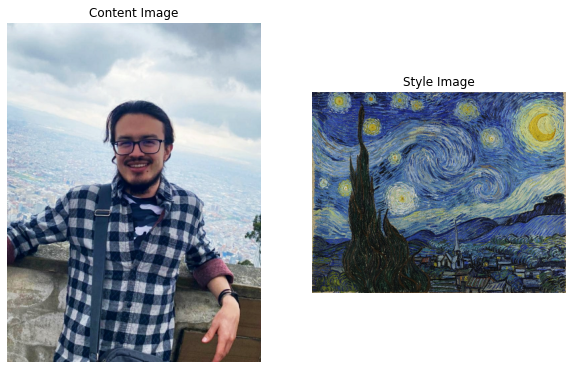

In [ ]:
gen.visualize_subplot(
    [content_image_array, style_image_array], 
    ["Content Image", "Style Image"], (1, 2), 
    (10, 10),
)

In [ ]:
model = keras.applications.VGG19(include_top=False, weights="imagenet")

In [ ]:
for layer in model.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ["block5_conv2"]
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## **Modelado**

In [ ]:
def extractor_model(
    base_model: keras.Model, 
    layer_names: List[str],
) -> keras.Model:
    """
    Function to load a base model
    :param base_model: The base model
    :type base_model: keras.Model
    :param layer_names: The list of layer names
    :type layer_names: List[str]
    :return: The model created from the layer names
    :rtype: keras.Model
    """
    # model = keras.applications.VGG19(include_top=False, weights="imagenet")
    base_model.trainable = False

    outputs = [base_model.get_layer(name).output for name in layer_names]

    model = keras.Model(inputs=[base_model.input], outputs=outputs)
    return model

In [ ]:
base_model = keras.applications.VGG19(include_top=False, weights="imagenet")
style_extractor = extractor_model(base_model, style_layers)
style_outputs = style_extractor(style_image * 255)

In [ ]:
for name, output in zip(style_layers, style_outputs):
    print(f"Layer name: {name}")
    print(f"Output Shape: {output.shape}")

Layer name: block1_conv1
Output Shape: (1, 512, 486, 64)
Layer name: block2_conv1
Output Shape: (1, 256, 243, 128)
Layer name: block3_conv1
Output Shape: (1, 128, 121, 256)
Layer name: block4_conv1
Output Shape: (1, 64, 60, 512)
Layer name: block5_conv1
Output Shape: (1, 32, 30, 512)


### **Funciones de Pérdida**

**Convenio de Sumatoria de Einstein**
$$C_{i,k} = \sum_j A_{i,j} * B_{j,k}$$

**Gramiano**
$$C^l_{c,d} = \frac{\sum_{ij} F^l_{ijc}(x) * F^l_{ijd}(x)}{IJ} \to \frac{F^l_{ijc}(x) * F^l_{ijd}(x)}{IJ}$$

In [ ]:
def gramian(input_tensor: tf.Tensor) -> tf.Tensor:
    """
    Function to calculate the Gram Matrix
    :param input_tensor: The tensor to calculate the gramian
    :type input_tensor: tf.Tensor
    :return: The Gram Marix calculated
    :rtype: tf.Tensor
    """
    # Einstein Sumatory
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

In [ ]:
class StyleContentModel(keras.Model):
    def __init__(
        self, base_model: keras.Model, 
        style_layers: List[str], 
        content_layers: List[str],
    ):
        """
        Initializer function
        :param base_model: The base model of the 
        Style Transfer Model
        :type base_model: keras.Model
        :param style_layers: The list of layers of style
        :type style_layers: List[str]
        :param content_layers: The list of layers of content
        :type content_layers: List[str]
        """
        super(StyleContentModel, self).__init__()
        self.model = extractor_model(
            base_model, style_layers + content_layers,
        )
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.model.trainable = False

    def call(self, inputs: tf.Tensor) -> Dict[str, Dict[str, tf.Tensor]]:
        """
        Forward pass
        :param inputs: The tensor inputs
        :type inputs: tf.Tensor
        :return: The resulting forward pass
        associated to the content pass and the style pass
        :rtype: Dict[str, Dict[str, tf.Tensor]]
        """
        inputs = inputs * 255.
        # Preprocess image
        preprocessed_input = keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.model(preprocessed_input)
        style_outputs, content_outputs = (
            outputs[:self.num_style_layers],
            outputs[self.num_style_layers:],
        )

        # Calculate gramian for each style output
        style_outputs = [
            gramian(style_output) 
            for style_output in style_outputs
        ]

        # Create the dictionaries
        content_dict = {
            content_name: value
            for content_name, value in zip(
                self.content_layers, content_outputs,
            )
        }
        
        style_dict = {
            style_name: value
            for style_name, value
            in zip(
                self.style_layers, style_outputs,
            )
        }

        return {
            "content": content_dict,
            "style": style_dict,
        }

In [ ]:
extractor = StyleContentModel(base_model, style_layers, content_layers)

In [ ]:
results = extractor(tf.constant(content_image))

In [ ]:
print("Styles:")
for name, output in sorted(results["style"].items()):
    print(f"Layer name: {name}")
    print(f"Output shape: {output.shape}")

print("Contents:")
for name, output in sorted(results["content"].items()):
    print(f"Layer name: {name}")
    print(f"Output shape: {output.shape}")

Styles:
Layer name: block1_conv1
Output shape: (1, 64, 64)
Layer name: block2_conv1
Output shape: (1, 128, 128)
Layer name: block3_conv1
Output shape: (1, 256, 256)
Layer name: block4_conv1
Output shape: (1, 512, 512)
Layer name: block5_conv1
Output shape: (1, 512, 512)
Contents:
Layer name: block5_conv2
Output shape: (1, 32, 23, 512)


In [ ]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [ ]:
image = tf.Variable(content_image)

In [ ]:
optimizer = keras.optimizers.Adam(
    learning_rate=1e-3, beta_1=0.99,
    epsilon=1e-1,
)

style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30

In [ ]:
def style_content_loss(
    outputs: Dict[str, Dict[str, tf.Tensor]],
) -> Tuple[float]:
    """
    Function to calculate the style and content loss
    :param outputs: The outputs of the forward pass.
    This includes the style and content outputs
    :type outputs: Dict[str, Dict[str, tf.Tensor]]
    :return: The total loss, the style loss and the content loss
    :rtype: Tuple[float]
    """
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    # Cumulative sum of quadratic error
    style_loss = tf.add_n(
        [
            tf.reduce_mean(
                (style_outputs[name] - style_targets[name]) ** 2,
            )
            for name in style_outputs.keys()
        ],
    )
    # Weights the loss
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n(
        [
            tf.reduce_mean(
                (content_outputs[name] - content_targets[name]) ** 2,
            )
            for name in content_outputs.keys()
        ],
    )
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss, style_loss, content_loss

In [ ]:
@tf.function
def train_step(image: tf.Tensor) -> Tuple[float]:
    """
    Function of train step
    :param image: The image on which the gradient 
    is going to be applied
    :type image: tf.Tensor
    :return: The style loss and the content loss
    :rtype: Tuple[float]
    """
    # Create the gradient buffer
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        # Style and content loss
        loss, style_loss, content_loss = style_content_loss(outputs)
        # Noise deletion with total variation
        loss += total_variation_weight * tf.image.total_variation(image)
    # The gradient calculated w.r.t the image
    grad = tape.gradient(loss, image)
    # Gradients applied over the image
    optimizer.apply_gradients([(grad, image)])
    image.assign(
        tf.clip_by_value(
            image, clip_value_min=0.0, clip_value_max=1.0,
        ),
    )
    return style_loss, content_loss

In [ ]:
epochs = 20
steps_per_epoch = 100

for n in range(epochs):
    bar = tqdm(range(steps_per_epoch))
    bar.set_description(f"Epoch: {n+1}/{epochs}")
    status = OrderedDict()
    for m in bar:
        style_loss, content_loss = train_step(image)
        status["style_loss"] = style_loss.numpy()
        status["content_loss"] = content_loss.numpy()
        bar.set_postfix(status)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## **Visualización de Resultados**

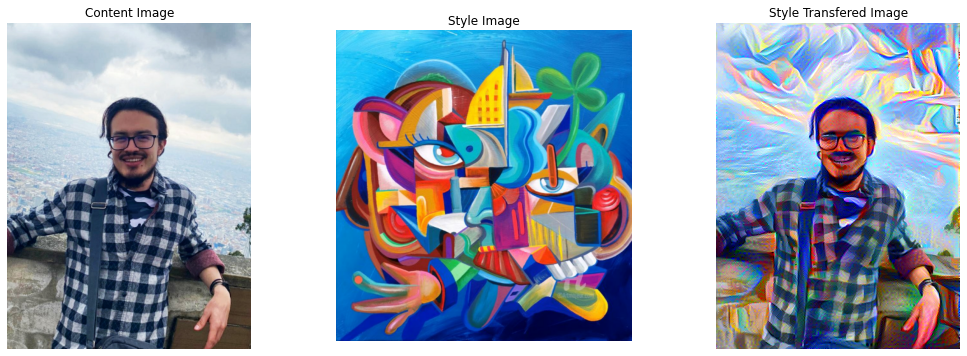

In [ ]:
styled_content_image = tensor_to_image(image)
gen.visualize_subplot(
    [content_image_array, style_image_array, styled_content_image],
    ["Content Image", "Style Image", "Style Transfered Image"],
    (1, 3), (18, 6),
)
plt.savefig("fig.png")